Предсказания локаций снятия наличных в банкоматах на основе транзакций клиентов банка.

In [1]:
!pip install h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import h3
#import typer
#import joblib

In [3]:
# Создание модели MLP
# input_shape = (input_size,)  форма входных данных (здесь - input_size признаков)
def create_mlp_model(input_shape, dropout_prob):
    model = Sequential([
        #Dense(128, activation='relu', input_shape=input_shape),
        #Dropout(dropout_prob),
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(dropout_prob),
        Dense(32, activation='relu', input_shape=input_shape),
        #Dropout(dropout_prob),
        #Dense(16, activation='relu', input_shape=input_shape),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# Создание модели RNN
# input_shape - количество признаков (здесь - input_size)
# timesteps - количество временных шагов
def create_rnn_model(input_shape, timesteps=20):
    model = Sequential([
        LSTM(64, input_shape=(timesteps, input_shape), return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
class Parameters():
    def __init__(self, data_path):
        self.input_size = 10
        self.hidden_size = 10
        self.dropout_prob = 0.15
        self.epochs = 10
        self.batch_size = 32
        self.num_classes = 2
        self.data_path = data_path
        self.get_data(data_path)

    def get_data(self, data_path):

        # Загрузка файла с транзакциями клиентов. transactions_df.shape = (4151096, 11)
        transactions_df = pd.read_parquet(data_path + "transactions.parquet")
        target_df = pd.read_parquet(data_path + "target.parquet")

        # Загрузка информации о локациях банкоматов и локациях с транзакциями клиентов.
        self.hexses_target = pd.read_csv(data_path +'hexses_target.lst', header=None, names=['h3_09'])
        self.hexses_data = pd.read_csv(data_path +'hexses_data.lst', header=None, names=['h3_09'])

        #self.target_h3_09 =  target_df['h3_09'].unique()

        # !!! только для отладки уменьшаем размер transactions_df !!!
        transactions_df = transactions_df[:200000]   # Для всех данных получаю ошибку: Your session crashed after using all available RAM.

        #self.h3_09 =  transactions_df ['h3_09'].unique()    # Получение уникальных локаций, в которых были совершены транзакции
        self.transactions_df = transactions_df
        self.target_df = target_df

        # Получение уникальных локаций, в которых были совершены транзакции
        unique_locations = transactions_df['h3_09'].unique()

        # Определение количества уникальных локаций (классов)
        self.num_classes = int(len(unique_locations))
        #self.num_classes = int(len(self.h3_09))


        # Определение количества признаков
        self.input_size = transactions_df.shape[1]
        #self.input_size = transactions_df.drop(columns=['h3_09', 'customer_id']).shape[1]

In [6]:
# Загрузка hexses данных
def load_data(hexses_target_path, hexses_data_path):
    hexses_target = pd.read_csv(hexses_target_path, header=None, names=['h3_09'])
    hexses_data = pd.read_csv(hexses_data_path, header=None, names=['h3_09'])
    return hexses_target, hexses_data

In [7]:
# Создание целевой переменной, как средней вероятности снятия наличных в каждой локации.
def create_target_variable(data):

    # Группируем данные по локации и вычисляем среднее количество транзакций
    average_transactions_per_location = data.groupby('h3_09')['count'].mean()

    # Вычисляем общее количество транзакций по каждой локации
    total_transactions_per_location = data.groupby('h3_09')['count'].sum()

    # Вычисляем среднюю вероятность снятия наличных в каждой локации
    average_probability_per_location = average_transactions_per_location / total_transactions_per_location

    # Создаем новый столбец в исходном DataFrame, содержащий среднюю вероятность снятия наличных в каждой локации
    data['target_column'] = data['h3_09'].map(average_probability_per_location)

    return data

In [8]:
 # Cоздания целевой переменной, как вероятности снятия наличных в локациях банкоматов на основе транзакций клиентов банка.
def create_target_variable1(data):

    # Группировка данных по локациям и подсчет количества транзакций в каждой локации
    location_counts = data['h3_09'].value_counts()

    # Вычисление общего количества транзакций
    total_transactions = data.shape[0]

    # Создание целевой переменной - вероятности снятия наличных в каждой локации
    data['target_column'] = data['h3_09'].map(location_counts) / total_transactions

    return data

In [9]:
# Обработка и очистка данных
def preprocess_data(data):

      # Обработка и очистка данных
      data.dropna(inplace=True)            # удаление всех строк, содержащих пропущенные значения(NaN).

      # Создание признакового пространства
      # Преобразование категориального признака 'h3_09' с помощью One-Hot Encoding
      data = pd.get_dummies(data, columns=['h3_09'])

      # Преобразование категориального признака 'mcc_code' с помощью One-Hot Encoding
      #data = pd.get_dummies(data, columns=['mcc_code'])

      # Разделение данных на обучающий, валидационный и тестовый наборы
      train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
      validation_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

      # Масштабирование числовых признаков
      scaler = StandardScaler()
      numeric_features = ['customer_id', 'datetime_id', 'count', 'sum', 'avg', 'min', 'max', 'std', 'count_distinct', 'mcc_code']

      train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
      validation_data[numeric_features] = scaler.transform(validation_data[numeric_features])
      test_data[numeric_features] = scaler.transform(test_data[numeric_features])

      # Отдельно извлечь целевую переменную
      X_train = train_data.drop(columns=['target_column'])
      y_train = train_data['target_column']
      X_validation = validation_data.drop(columns=['target_column'])
      y_validation = validation_data['target_column']
      X_test = test_data.drop(columns=['target_column'])
      y_test = test_data['target_column']

      # Возвращение подготовленных данных
      return X_train, X_validation, X_test, y_train, y_validation, y_test

In [10]:
def mean_binary_cross_entropy(y_true, y_pred, eps = 1e-8):
    # Преобразуем предсказанные вероятности в массив numpy
    y_pred = np.array(y_pred)
    # Преобразуем истинные значения в массив numpy
    y_true = np.array(y_true)

    # Рассчитываем бинарную кросс-энтропию для каждого пользователя
    individual_cross_entropy = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # Ограничиваем логарифмы
    individual_cross_entropy = np.clip(individual_cross_entropy, eps, 1 - eps)

    # Усредняем кросс-энтропию по всем пользователям
    mean_cross_entropy = np.mean(individual_cross_entropy)

    return mean_cross_entropy

In [ ]:
'''
eps = 1e-8
mbce = (-np.log(np.clip(predictuion, eps, 1 - eps)) * target \
       -  np.log(np.clip(1 - predictuion, eps, 1 - eps)) * (1 - target)).sum(axis=1).mean()
'''

In [18]:
# Бинарная кросс-энтропия, усредненная на всех пользователях.
# Где predictuion - вектор предсказанных вероятностей, а target - целевая разметка.
def calculate_mbce(prediction, target, eps = 1e-8):

    # Преобразуем предсказанные вероятности в массив numpy
    prediction = np.array(prediction)
    # Преобразуем истинные значения в массив numpy
    target = np.array(target)

    mbce = (-np.log(np.clip(prediction, eps, 1 - eps)) * target \
           -  np.log(np.clip(1 - prediction, eps, 1 - eps)) * (1 - target)).sum(axis=1).mean()

    return mbce

In [12]:
def plot_map(target, transactions):
  coord_target = target.assign(
    lat = target['h3_09'].apply(lambda x: h3.h3_to_geo(x)[0]),
    lon = target['h3_09'].apply(lambda x: h3.h3_to_geo(x)[1]),
  )

  coord_target.head()

  coord_target.plot(x='lon', y='lat', kind='scatter', marker='.', alpha=0.1, figsize=(6, 6), label='Целевые');

  coord_transactions = transactions.assign(
    lat = transactions['h3_09'].apply(lambda x: h3.h3_to_geo(x)[0]),
    lon = transactions['h3_09'].apply(lambda x: h3.h3_to_geo(x)[1]),
  )

  coord_transactions.head()

  coord_transactions.plot(x='lon', y='lat', kind='scatter', marker='.', alpha=0.1, figsize=(6, 6), label='Транзакции');


In [13]:
def plot_history(history):
    # График точности
    plt.plot(history.history['accuracy'], label='Точность обучения')
    plt.plot(history.history['val_accuracy'], label='Точность валидации')
    plt.title('График точности')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    # График потерь
    plt.plot(history.history['loss'], label='Потери обучения')
    plt.plot(history.history['val_loss'], label='Потери валидации')
    plt.title('График потерь')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.show()

In [14]:
def plot_bar(y_test, y_pred, target_var_type):
    # Создаем столбчатую диаграмму
    plt.figure(figsize=(10, 6))

    plt.bar(np.arange(len(y_test)), y_pred.ravel(), color='skyblue')

    # Добавляем названия осей и заголовок
    plt.xlabel('Локация')
    plt.ylabel('Вероятность')
    plt.title('Вероятность снятия наличных в каждой локации.' + target_var_type)

    # Показываем график
    plt.xticks(rotation=45)  # Поворачиваем подписи по оси X
    plt.tight_layout()  # Автоматически подстраиваем размеры графика
    plt.show()

In [ ]:
#timesteps = 20  # Пример количества временных шагов

In [ ]:
# Пример использования модели RNN
#model = create_rnn_model(parameters.input_size, timesteps)

In [15]:
def save_model(model, data_root):
  # Путь для сохранения модели
  model_file = data_root + 'trained_model.pkl'

  # Сохранение модели
  with open(model_file, 'wb') as f:
      pickle.dump(model, f)

  print("Модель сохранена в файл:", model_file)

In [21]:
def main():

    data_root = '/content/'
    '''
    !cd /content && wget https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/DataFusion2024/Data/geo/hexses_target.lst
    !cd /content && wget https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/DataFusion2024/Data/geo/hexses_data.lst
    !cd /content && wget https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/DataFusion2024/Data/geo/transactions.parquet
    !cd /content && wget https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/DataFusion2024/Data/geo/target.parquet
    !cd /content && wget https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/DataFusion2024/Data/geo/moscow.parquet
    '''

    #data_root = Path('data/')
    #!ls $data_root
    #Path('features').mkdir(exist_ok=True) # Сюда мы будем складывать насчитанные признаки
    #Path('models').mkdir(exist_ok=True) # Здесь у нас будут лежать обученные модели

    # Загрузка данных и параметров
    parameters = Parameters(data_root)
    parameters.dropout_prob = 0.1
    parameters.epochs = 10
    parameters.batch_size = 32
    target_var_type = ''

    # Создание целевой переменной, как средней вероятности снятия наличных в каждой локации.
    data = create_target_variable(parameters.transactions_df)
    target_var_type = 'Целевая переменная, как средняя вероятность снятия наличных в каждой локации.'

    # Cоздания целевой переменной, как вероятности снятия наличных в локациях банкоматов на основе транзакций клиентов банка
    #data = create_target_variable1(parameters.transactions_df)
    #target_var_type = 'Целевая переменная, как вероятность снятия наличных в каждой локациях'

    # X_train - 80%, X_test - 10%, X_val - 10%
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(data)

    # Пример использования модели многослойного персептрона (MLP)
    # input_shape = (parameters.input_size,)  # Пример формы входных данных (input_size признаков)
    print('dropout:', parameters.dropout_prob)
    print('batch_size:', parameters.batch_size)
    print('Число эпох:',  parameters.epochs)
    print('Число слоёв модели MLP:', 2)

    model = create_mlp_model((X_train.shape[1],), parameters.dropout_prob)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.summary()  # Отобразить информацию о модели

    model.fit(X_train, y_train, epochs=parameters.epochs, batch_size=parameters.batch_size, validation_data=(X_val, y_val), verbose=0)

    # сохраняем модель
    save_model(model, data_root)

    history = model.history

    # Порог для преобразования вероятностей в бинарные метки
    threshold = 0.1

    # Предсказания модели на тестовом наборе данных для проверки
    y_pred = model.predict(X_test)  # Вероятности положительного класса

    # Построение графиков
    plot_history(history)
    plot_bar(y_test, y_pred, target_var_type)

    # Построение карт
    plot_map(parameters.target_df, parameters.transactions_df)

    # Преобразование непрерывных меток в целый формат
    y_test_binary = (y_test > threshold).astype(int)
    y_pred_binary = (y_pred > threshold).astype(int)

    # Вычисление ROC-AUC
    roc_auc = roc_auc_score(y_test_binary, y_pred_binary)
    print("ROC-AUC Score:", roc_auc)

    # Вычисление точности (Accuracy Score)
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    print("Точность:", accuracy)

    confusion_mat = confusion_matrix(y_test_binary, y_pred_binary)  # Матрица ошибок
    print("Матрица ошибок:\n", confusion_mat)

    # Вычисление F1-меры
    f1 = f1_score(y_test_binary, y_pred_binary)
    print("F1 Score:", f1)

    # Метрика соревнования — Mean Binary Cross Entropy т.е. бинарная кросс-энтропия, усредненная на всех пользователях.
    #print('Метрика соревнования как в задании — Mean Binary Cross Entropy:', calculate_mbce(y_test, y_pred))  # как в задании
    print('Метрика соревнования — Mean Binary Cross Entropy:', mean_binary_cross_entropy(y_test, y_pred))


dropout: 0.1
batch_size: 32
Число эпох: 10
Число слоёв модели MLP: 2
Модель сохранена в файл: /content/trained_model.pkl
268/268 [==============================] - 1s 2ms/step


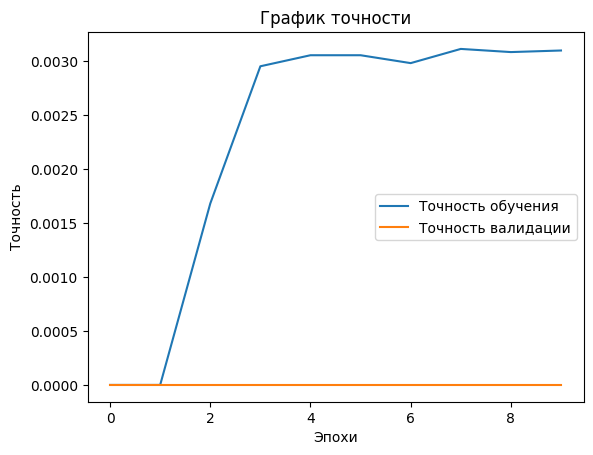

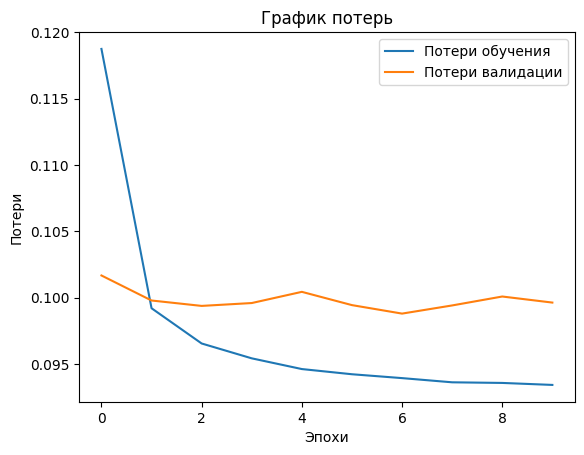

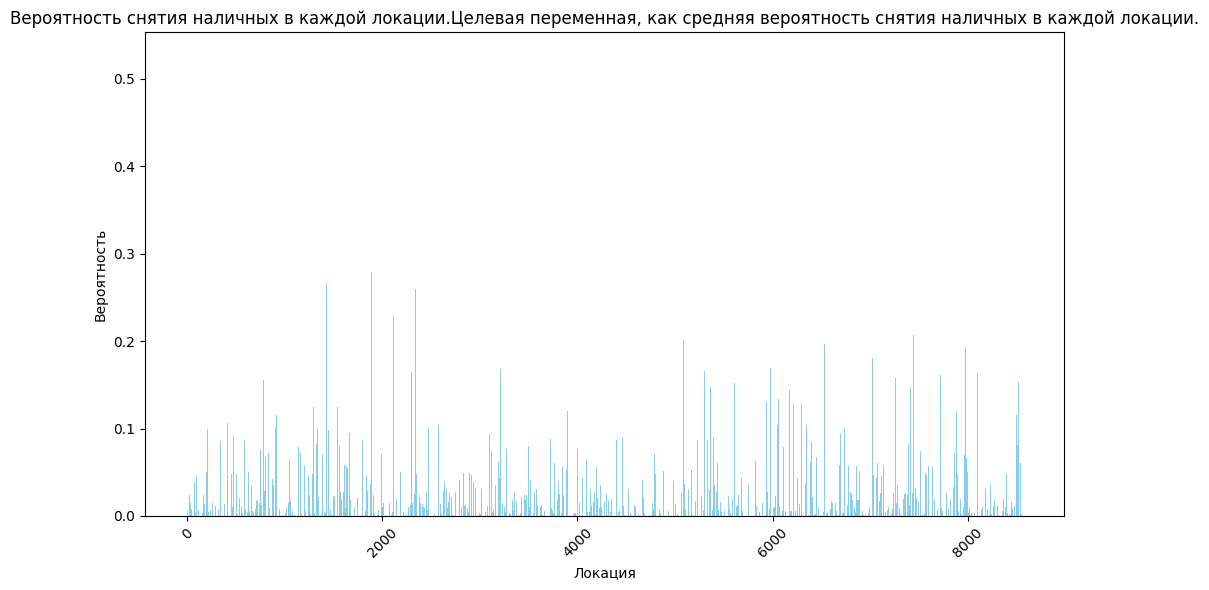

ROC-AUC Score: 0.9694439982330028
Точность: 0.9903003389038214
Матрица ошибок:
 [[8019   57]
 [  26  455]]
F1 Score: 0.9164149043303121
Метрика соревнования — Mean Binary Cross Entropy: 1948.2418304133676
Другая Метрика соревнования — Mean Binary Cross Entropy: 0.16455384968241382


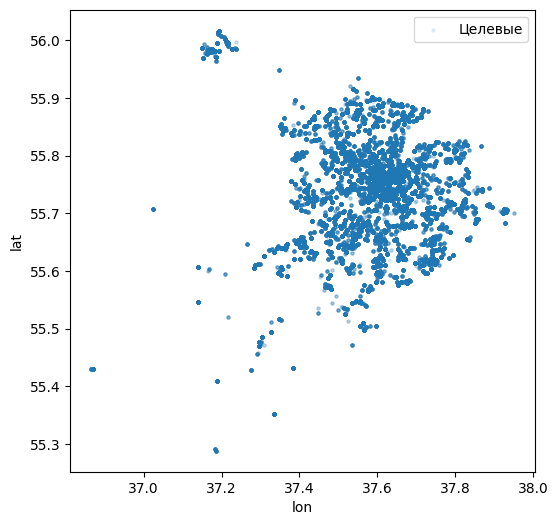

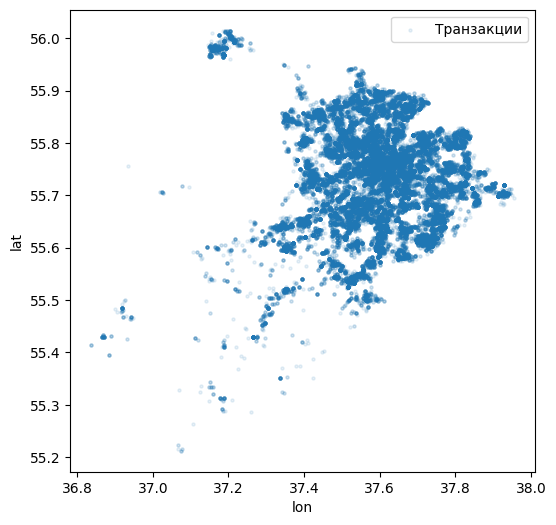

In [20]:
if __name__ == "__main__":
     main()